# K-Means clustering on the handwritten digits data

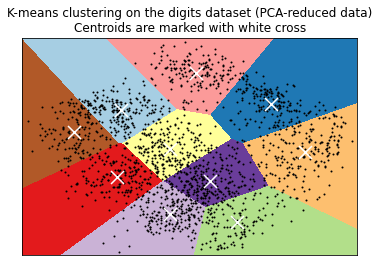

In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Comparison of the K-Means and MiniBatchKMeans clustering algorithms
We want to compare the performance of the MiniBatchKMeans and KMeans: the MiniBatchKMeans is faster, but gives slightly different results (see Mini Batch K-Means).

We will cluster a set of data, first with KMeans and then with MiniBatchKMeans, and plot the results. We will also plot the points that are labelled differently between the two algorithms.

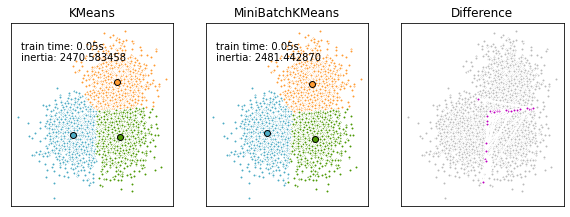

In [4]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

# #############################################################################
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# #############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

# #############################################################################
# Plot result

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_,
                                  mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == k))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

# Hierarchical clustering: structured vs unstructured ward
In a first step, the hierarchical clustering is performed without connectivity constraints on the structure and is solely based on distance, whereas in a second step the clustering is restricted to the k-Nearest Neighbors graph: it’s a hierarchical clustering with structure prior.

Some of the clusters learned without connectivity constraints do not respect the structure of the swiss roll and extend across different folds of the manifolds. On the opposite, when opposing connectivity constraints, the clusters form a nice parcellation of the swiss roll.

Compute unstructured hierarchical clustering...
Elapsed time: 0.08s
Number of points: 1500
Compute structured hierarchical clustering...
Elapsed time: 0.14s
Number of points: 1500


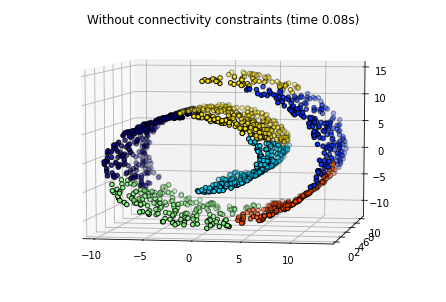

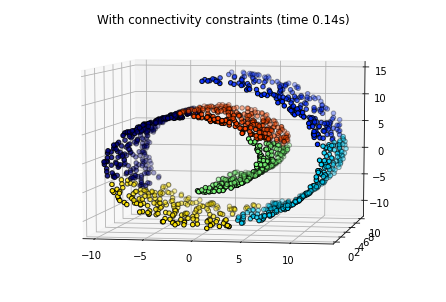

In [5]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll

# #############################################################################
# Generate data (swiss roll dataset)
n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise=noise)
# Make it thinner
X[:, 1] *= .5

# #############################################################################
# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)


# #############################################################################
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)

plt.show()

# Spectral clustering for image segmentation
In these settings, the Spectral clustering approach solves the problem know as ‘normalized graph cuts’: the image is seen as a graph of connected voxels, and the spectral clustering algorithm amounts to choosing graph cuts defining regions while minimizing the ratio of the gradient along the cut, and the volume of the region.

As the algorithm tries to balance the volume (ie balance the region sizes), if we take circles with different sizes, the segmentation fails.

In addition, as there is no useful information in the intensity of the image, or its gradient, we choose to perform the spectral clustering on a graph that is only weakly informed by the gradient. This is close to performing a Voronoi partition of the graph.

In addition, we use the mask of the objects to restrict the graph to the outline of the objects. In this example, we are interested in separating the objects one from the other, and not from the background.



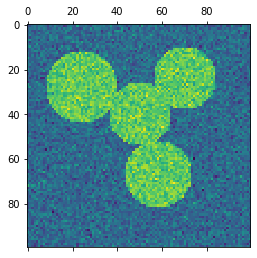

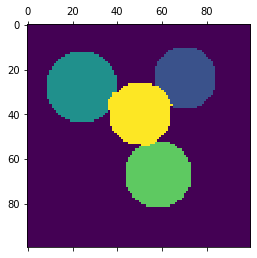

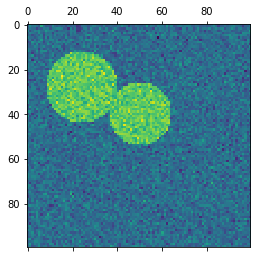

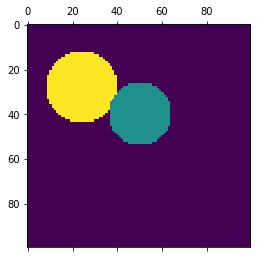

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

# #############################################################################
# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

plt.show()

# K-means Clustering
The plots display firstly what a K-means algorithm would yield using three clusters. It is then shown what the effect of a bad initialization is on the classification process: By setting n_init to only 1 (default is 10), the amount of times that the algorithm will be run with different centroid seeds is reduced. The next plot displays what using eight clusters would deliver and finally the ground truth.

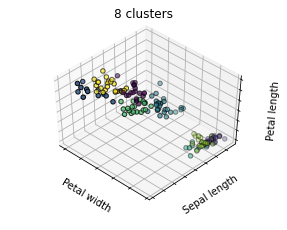

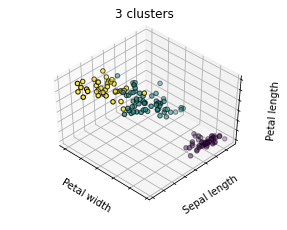

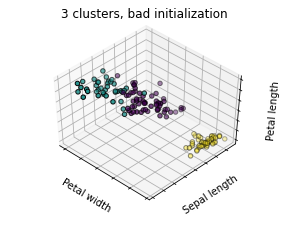

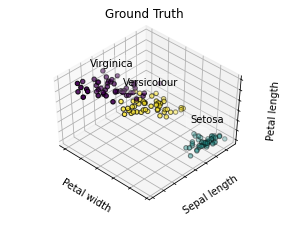

In [7]:
import numpy as np
import matplotlib.pyplot as plt
# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=3)),
              ('k_means_iris_bad_init', KMeans(n_clusters=3, n_init=1,
                                               init='random'))]

fignum = 1
titles = ['8 clusters', '3 clusters', '3 clusters, bad initialization']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2],
               c=labels.astype(float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Ground Truth')
ax.dist = 12

fig.show()